In [2]:
%run /Users/maayanlab/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

/Users/maayanlab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [24]:
from sklearn.decomposition import PCA

In [3]:
count_dataframe = pd.read_table('./s2-expression.dir/kallisto/kallisto-counts.txt', index_col='gene_symbol')
count_dataframe.head()

sample_10_1  sample_10_2  sample_10_3  sample_11_1  sample_11_2  \
gene_symbol                                                                    
A1BG                 190          190          156          178          171   
A1CF                  17           10           25           19           15   
A2M                 2891         3021         5963         2489         3302   
A2ML1                 34           12           26           28           21   
A3GALT2                0            0            1            0            1   

             sample_11_3  sample_12_1  sample_12_2  sample_12_3  sample_13_1  \
gene_symbol                                                                    
A1BG                 187          183          183          177          231   
A1CF                  17           31           14           34           17   
A2M                 8057         2012         3218        19624         3510   
A2ML1                 23           30           13           33           24   
A3GALT2                0            1            0            2            2   

                ...      sample_7_2  sample_7_3  sample_7_4  sample_8_1  \
gene_symbol     ...                                                       
A1BG            ...             219         173         156         211   
A1CF            ...               8          17          17          16   
A2M             ...            2942        7502       12873        4365   
A2ML1           ...              20          18          10          44   
A3GALT2         ...               1           0           0           0   

             sample_8_2  sample_8_3  sample_8_4  sample_9_1  sample_9_2  \
gene_symbol                                                               
A1BG                186         153         219         233         205   
A1CF                  8          17          27          24          27   
A2M                2936        6728       26207        3652        2474   
A2ML1                 4           9          23          18          43   
A3GALT2               0           0           0           1           1   

             sample_9_3  
gene_symbol              
A1BG                173  
A1CF                 21  
A2M                6945  
A2ML1                19  
A3GALT2               0  

[5 rows x 115 columns]

In [5]:
metadata_dataframe = pd.read_table('./rawdata/metadata/dubois-metadata.txt', index_col='Sample')
metadata_dataframe.head()

Diff Condition             Description
Sample                                           
sample_5_1  148   Control  Control cardiomyocytes
sample_5_2  149   Control  Control cardiomyocytes
sample_5_3  150   Control  Control cardiomyocytes
sample_6_1  148   + delta      PPAR delta agonist
sample_6_2  149   + delta      PPAR delta agonist

## 1. PCA

In [155]:
def plot_pca(group_name, conditions):
    
    # Subset
    metadata_dataframe_subset = metadata_dataframe.query('Condition in {}'.format(conditions))
    count_dataframe_subset = count_dataframe[metadata_dataframe_subset.index]

    # Filter and normalize
    logcpm_dataframe_subset = np.log10((count_dataframe_subset/count_dataframe_subset.sum())*10**6+1)
    gene_subset = logcpm_dataframe_subset.var(axis=1).sort_values(ascending=False).index[:1000]
    zscore_dataframe = logcpm_dataframe_subset.loc[gene_subset].T.apply(ss.zscore).T

    # Run PCA
    pca=PCA(n_components=2)
    pca.fit(zscore_dataframe)
    var_explained = ['PC'+str((i+1))+' ('+str(round(e*100, 1))+'% var. explained)' for i, e in enumerate(pca.explained_variance_ratio_)]

    # Merge
    pca_dataframe = pd.DataFrame(pca.components_, columns=zscore_dataframe.columns, index=['PC{}'.format(x+1) for x in range(len(pca.components_))]).T
    plot_dataframe = pca_dataframe.merge(metadata_dataframe, left_index=True, right_index=True)

    %R -i plot_dataframe,var_explained,group_name -h 1000 -w 2700 -r 300 sample_pca(plot_dataframe, var_explained, group_name);

In [156]:
%%R -i plot_dataframe,var_explained -h 1000 -w 2000 -r 300

sample_pca <- function(plot_dataframe, var_explained, group_name) {
    gp1 <- ggplot(plot_dataframe, aes(x=PC1, y=PC2, color=Condition)) +
        geom_point(size=4) +
        labs(title = group_name, x = var_explained[[1]], y = var_explained[[2]]) +
        theme_classic() +
        theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0), plot.title = element_text(hjust = 0.5))
    gp2 <- ggplot(plot_dataframe, aes(x=PC1, y=PC2, color=Diff)) +
        geom_point(size=4) +
        labs(title = group_name, x = var_explained[[1]], y = var_explained[[2]]) +
        theme_classic() +
        theme(axis.title.x = element_text(vjust=-1), axis.title.y = element_text(vjust=2.5), axis.line = element_line(colour = 'black', size=0.2), strip.background = element_rect(color='black', fill='white', size=0), plot.title = element_text(hjust = 0.5))
    require(gridExtra)
    grid.arrange(gp1, gp2, ncol=2)
}


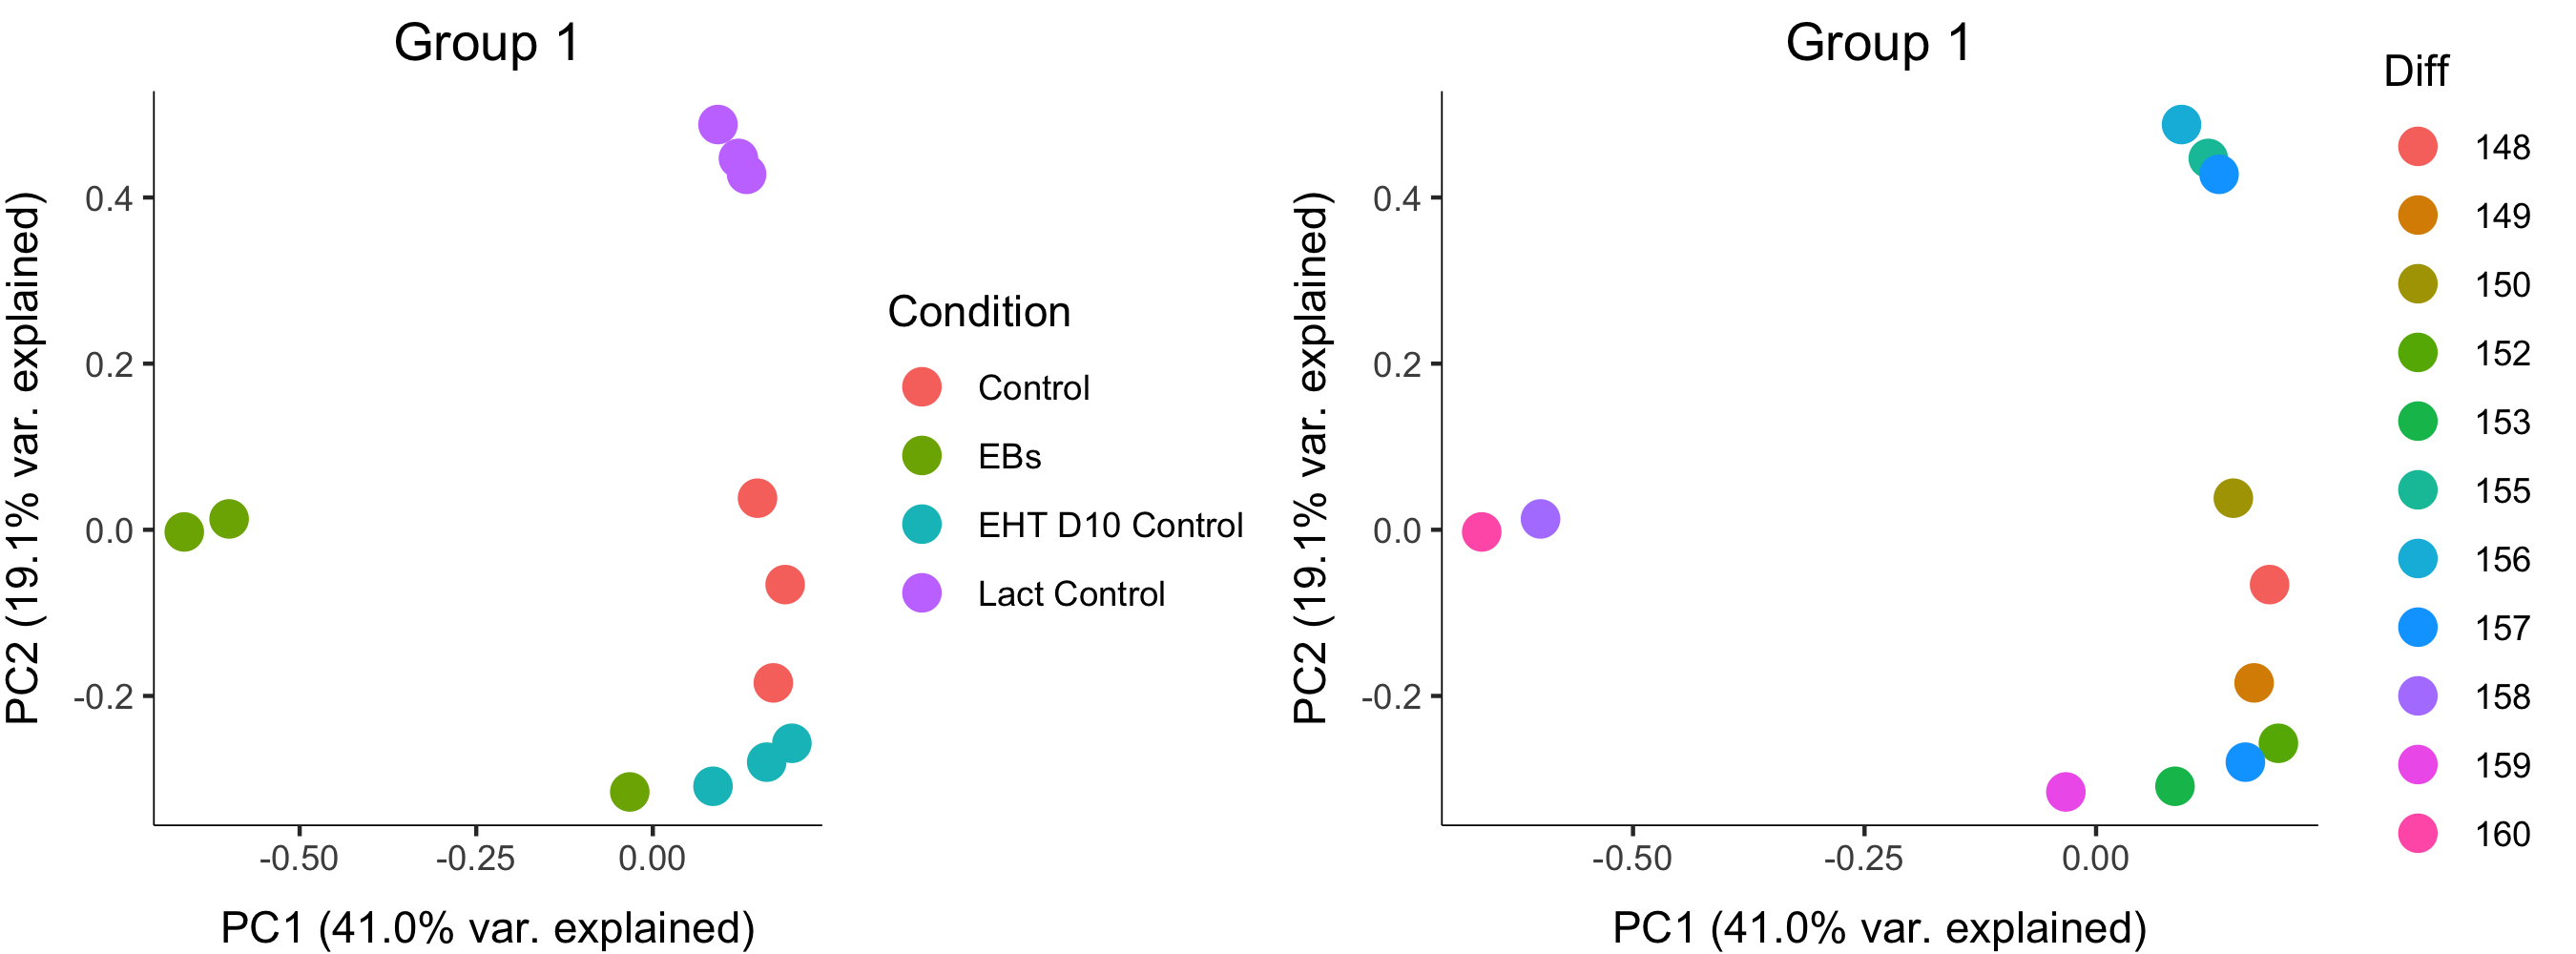

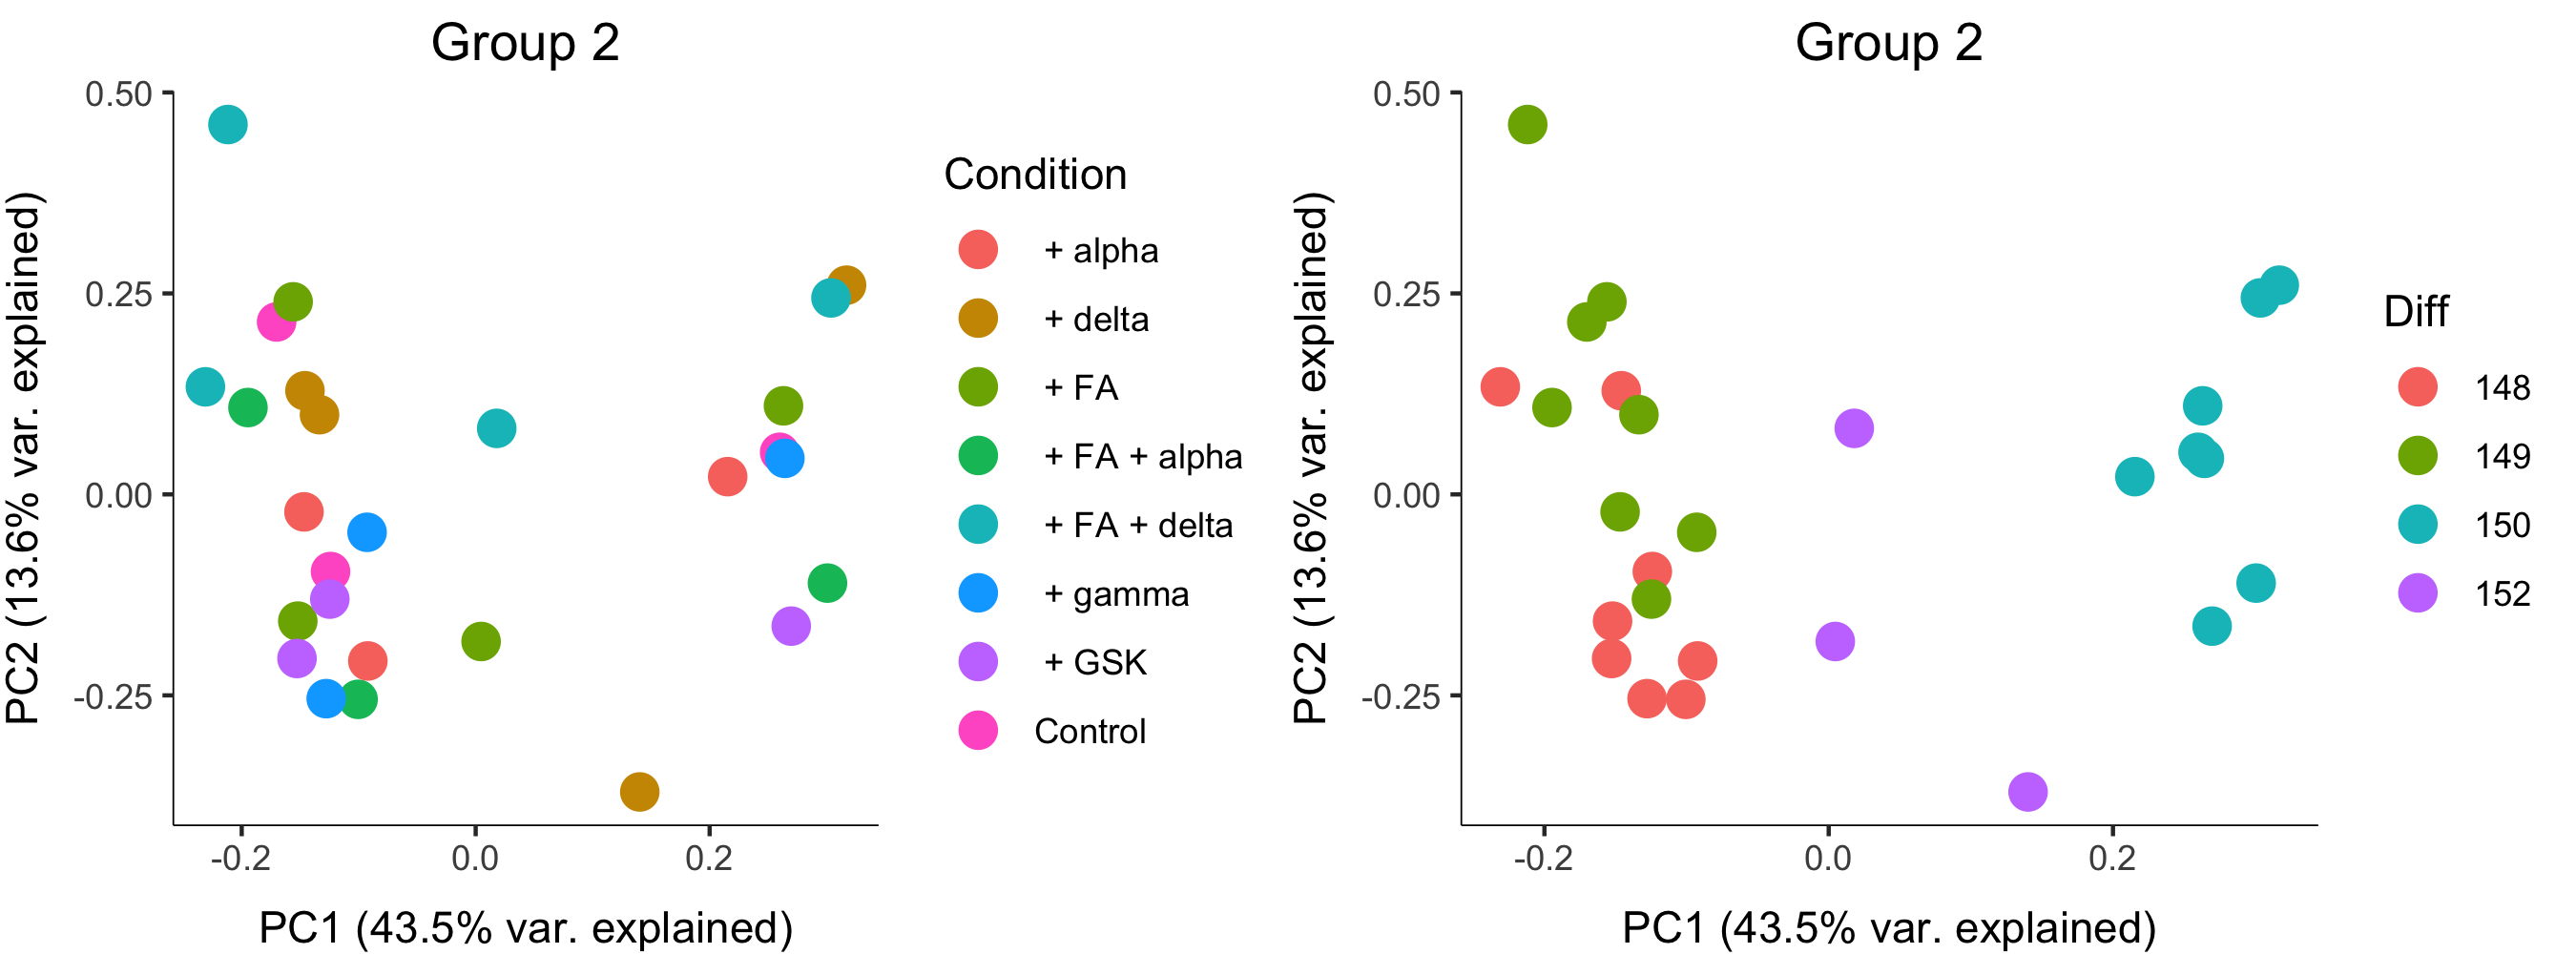

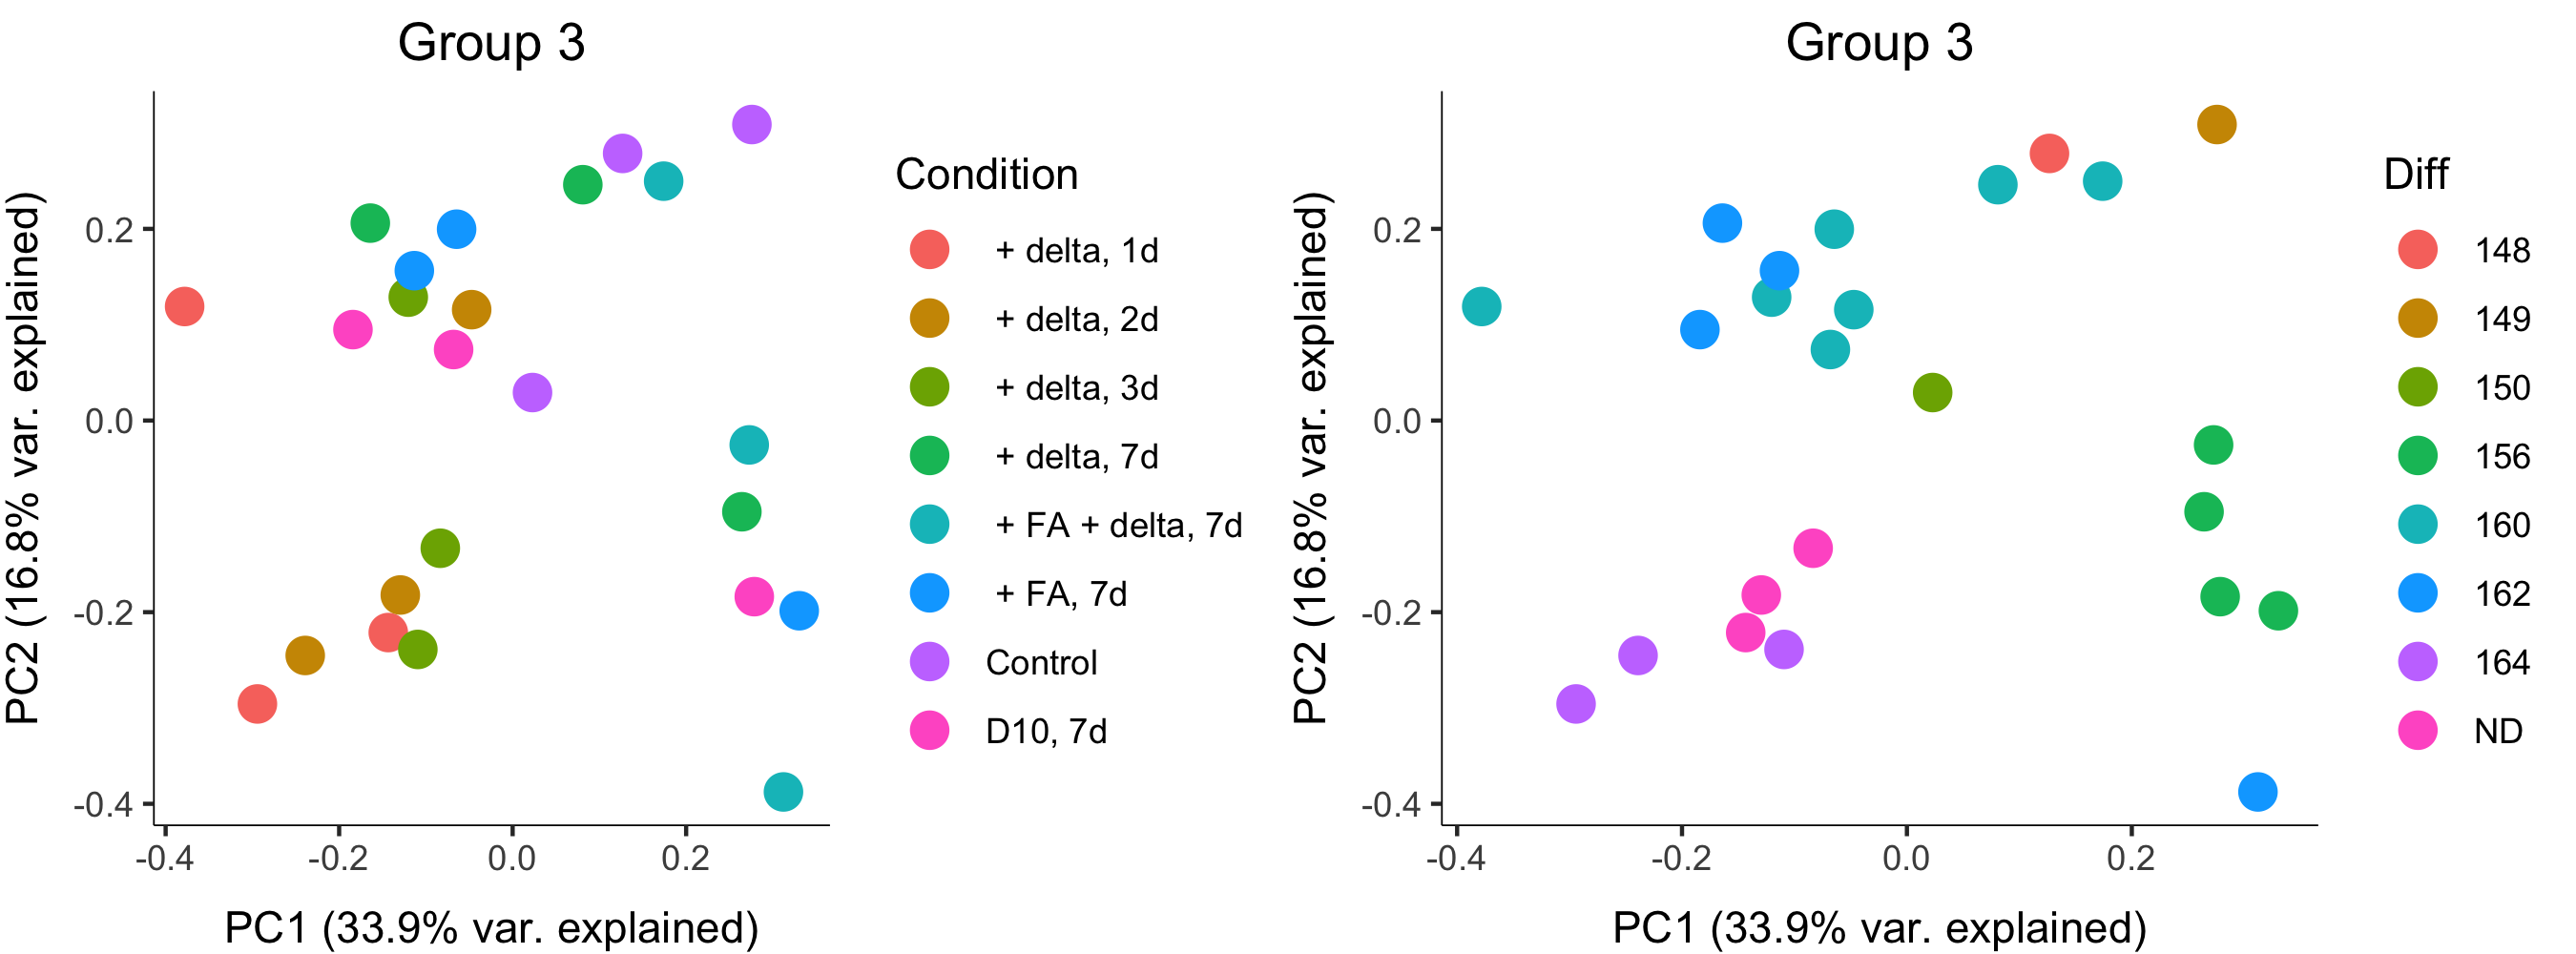

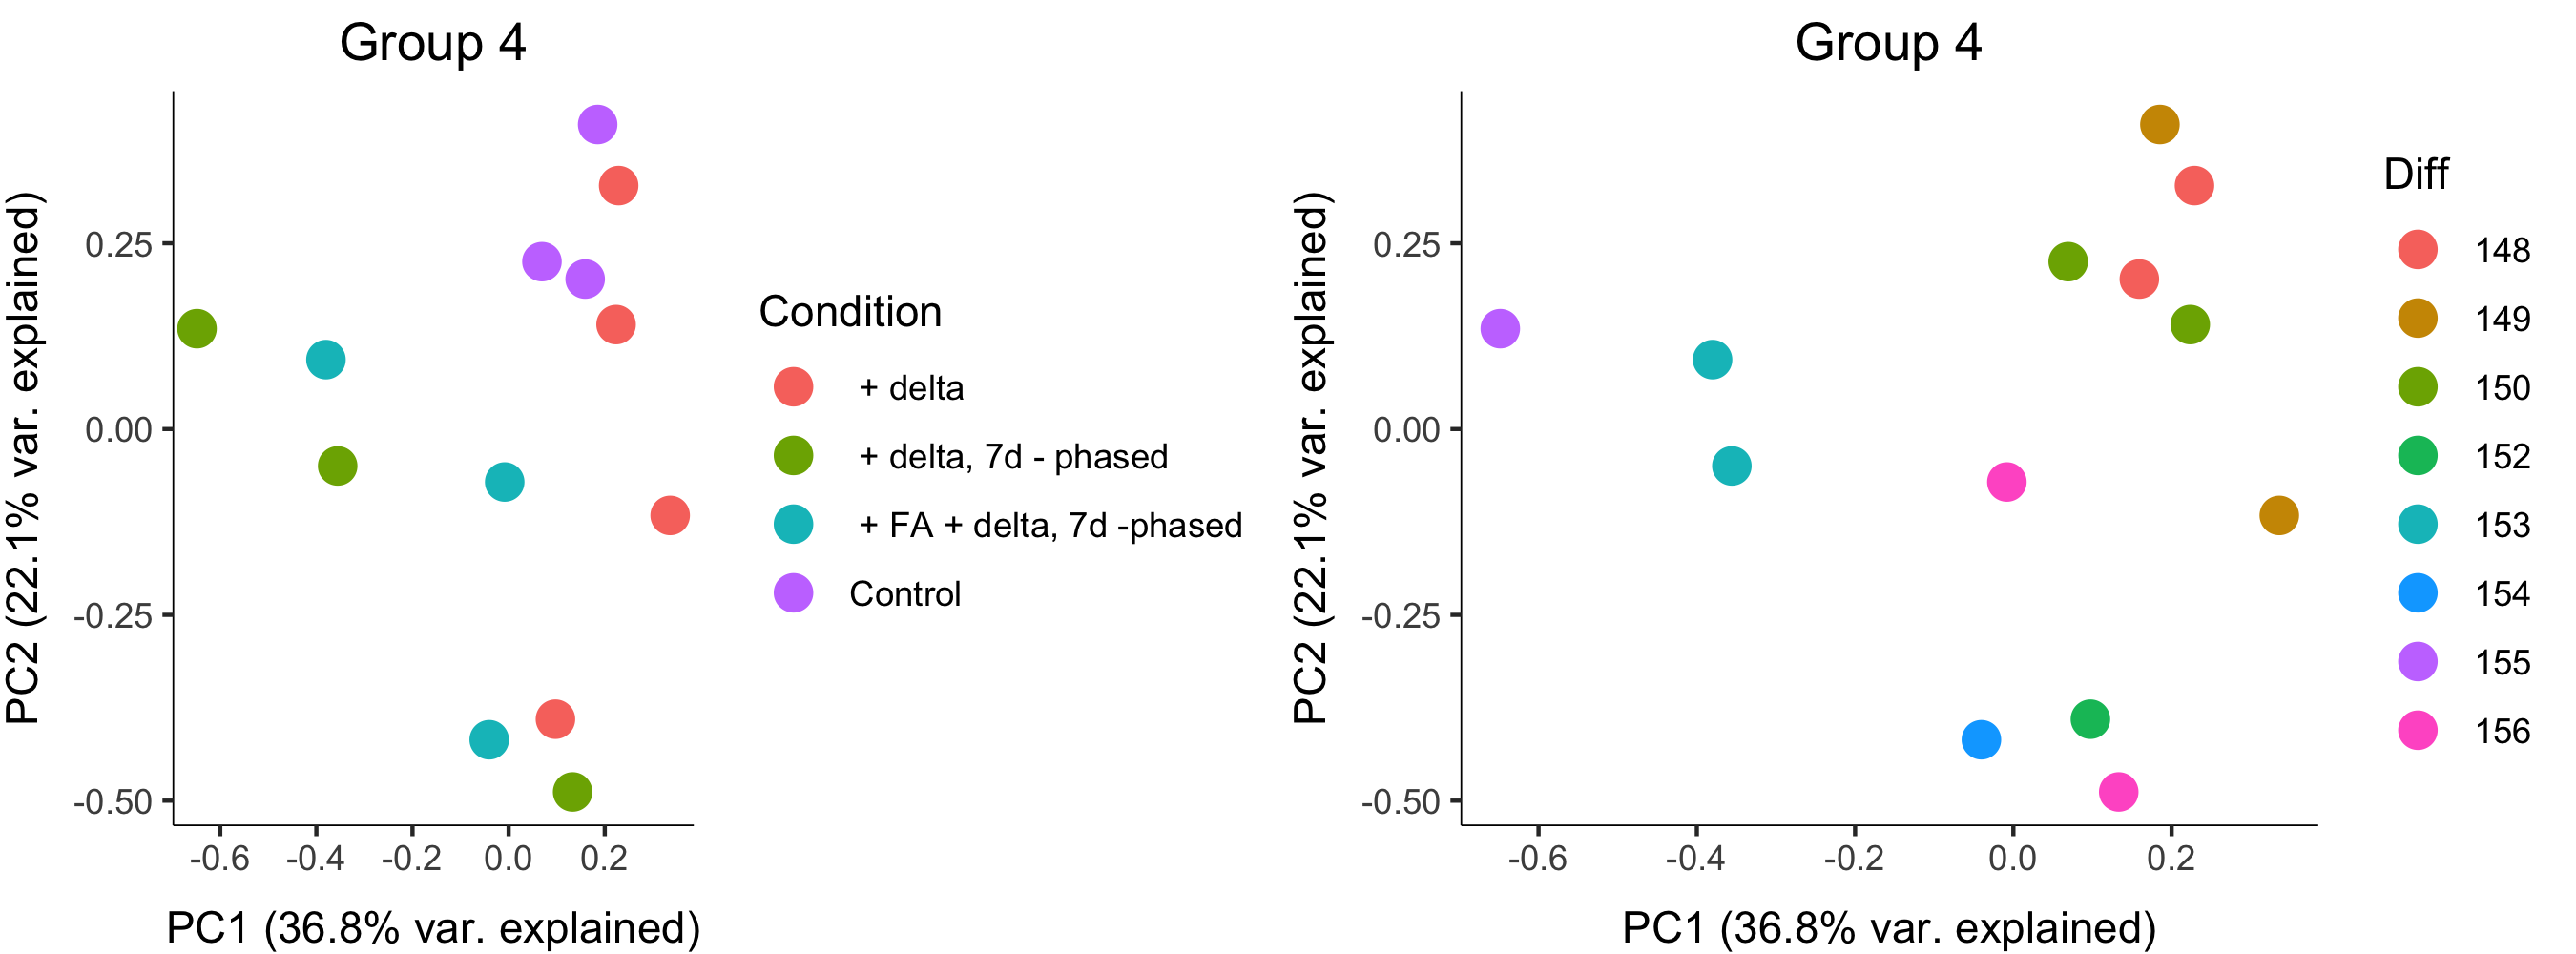

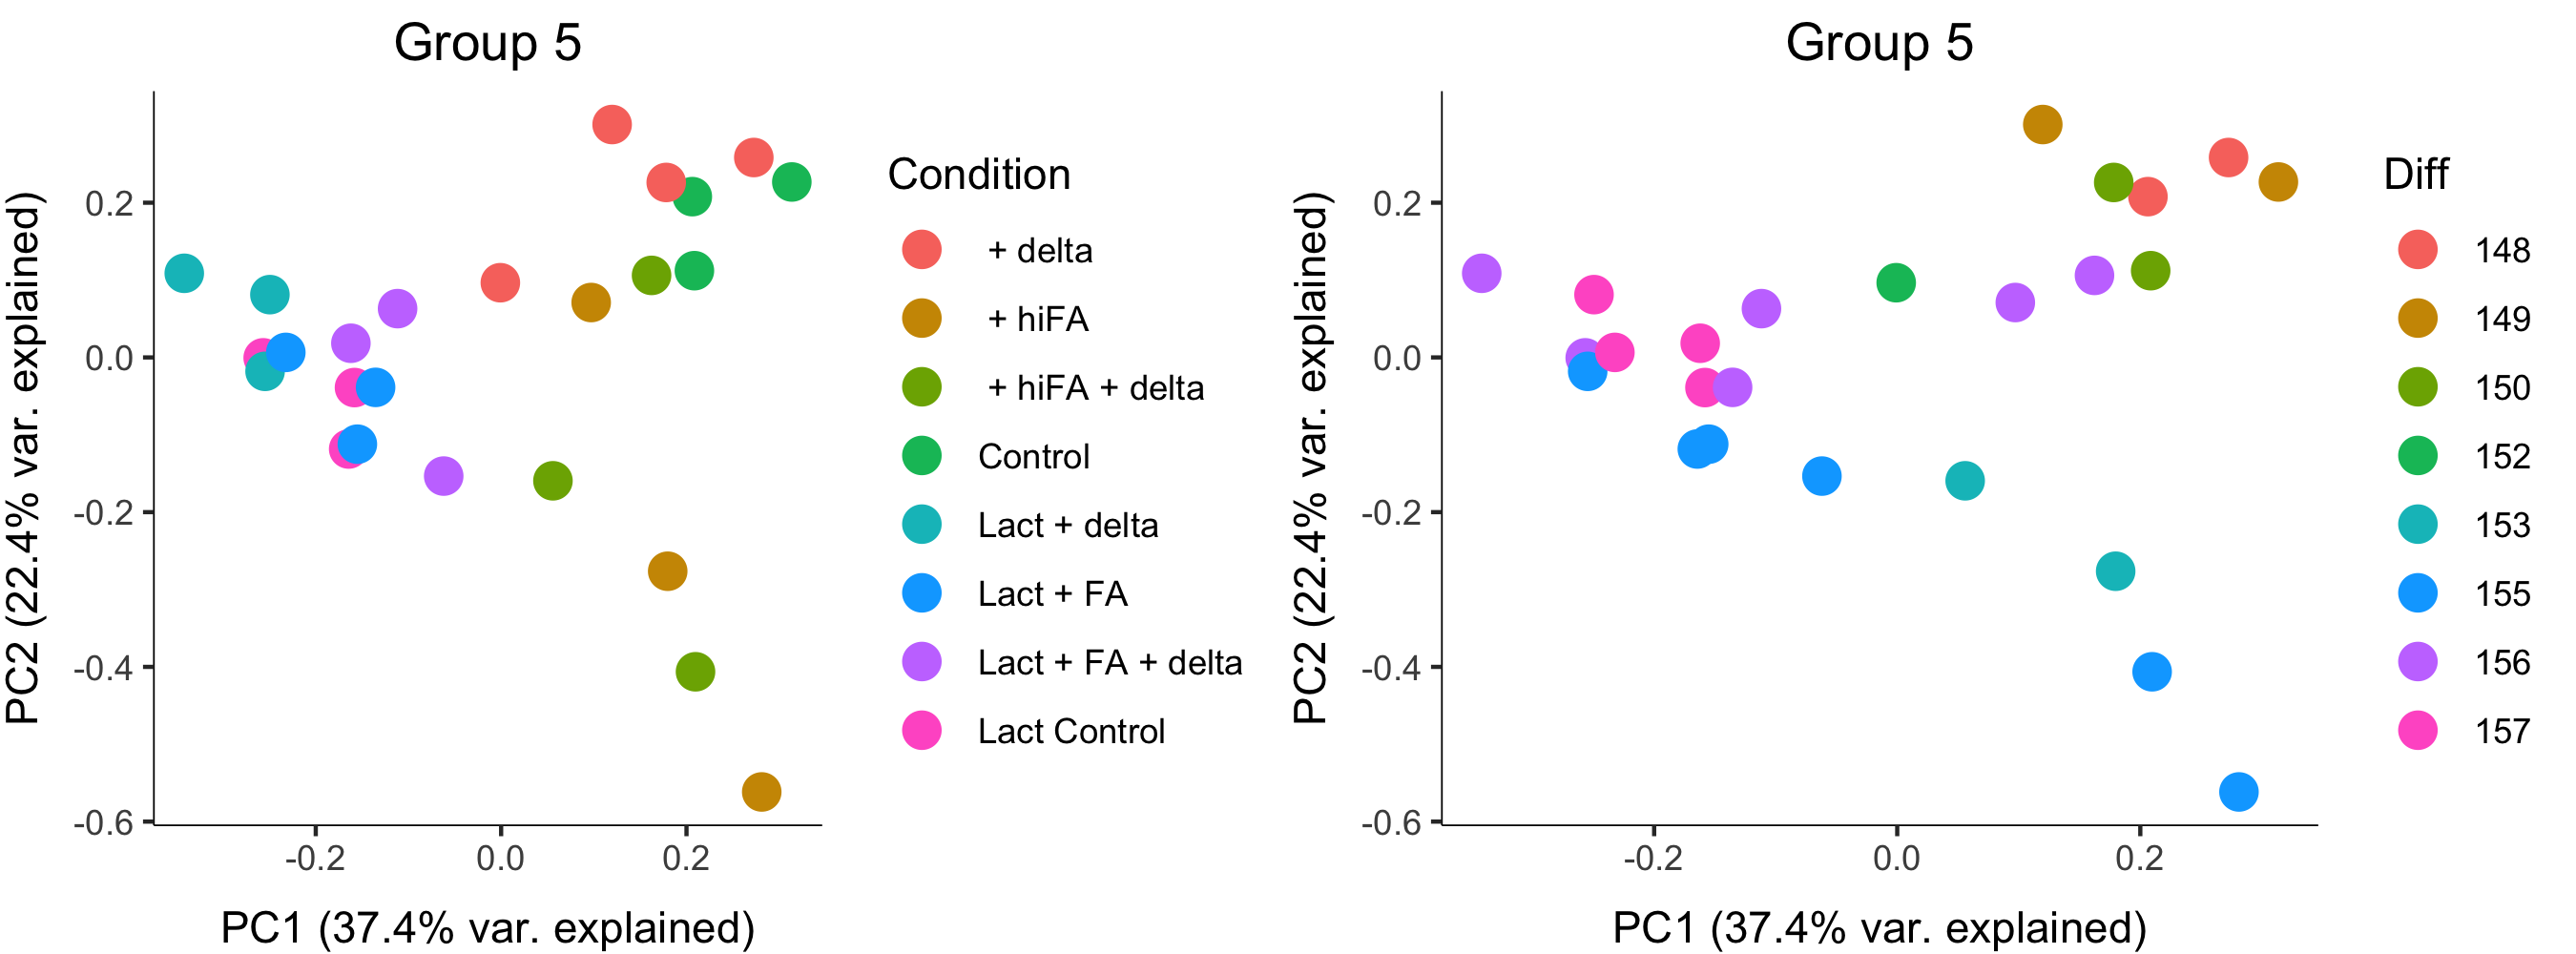

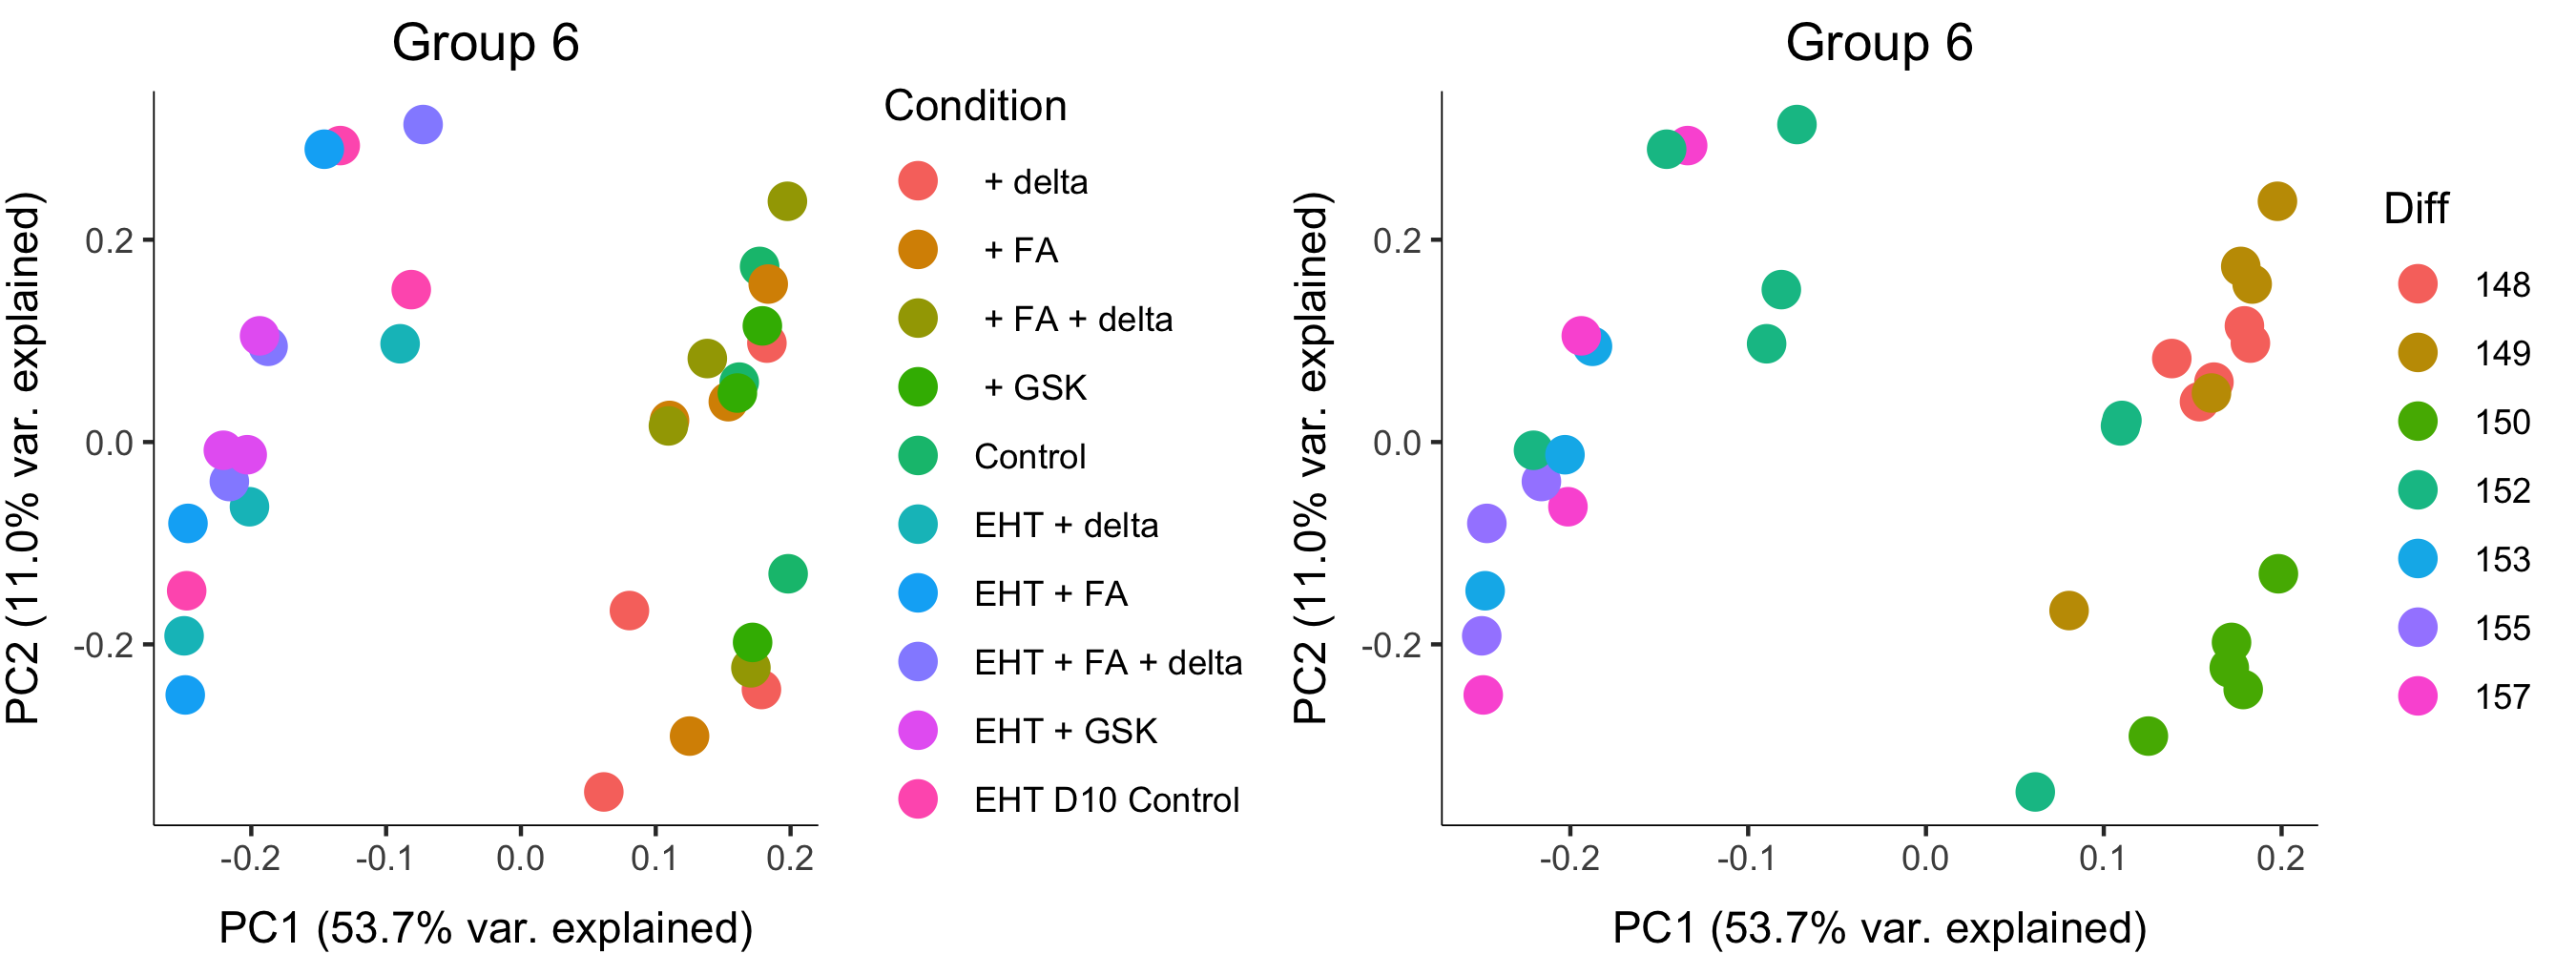

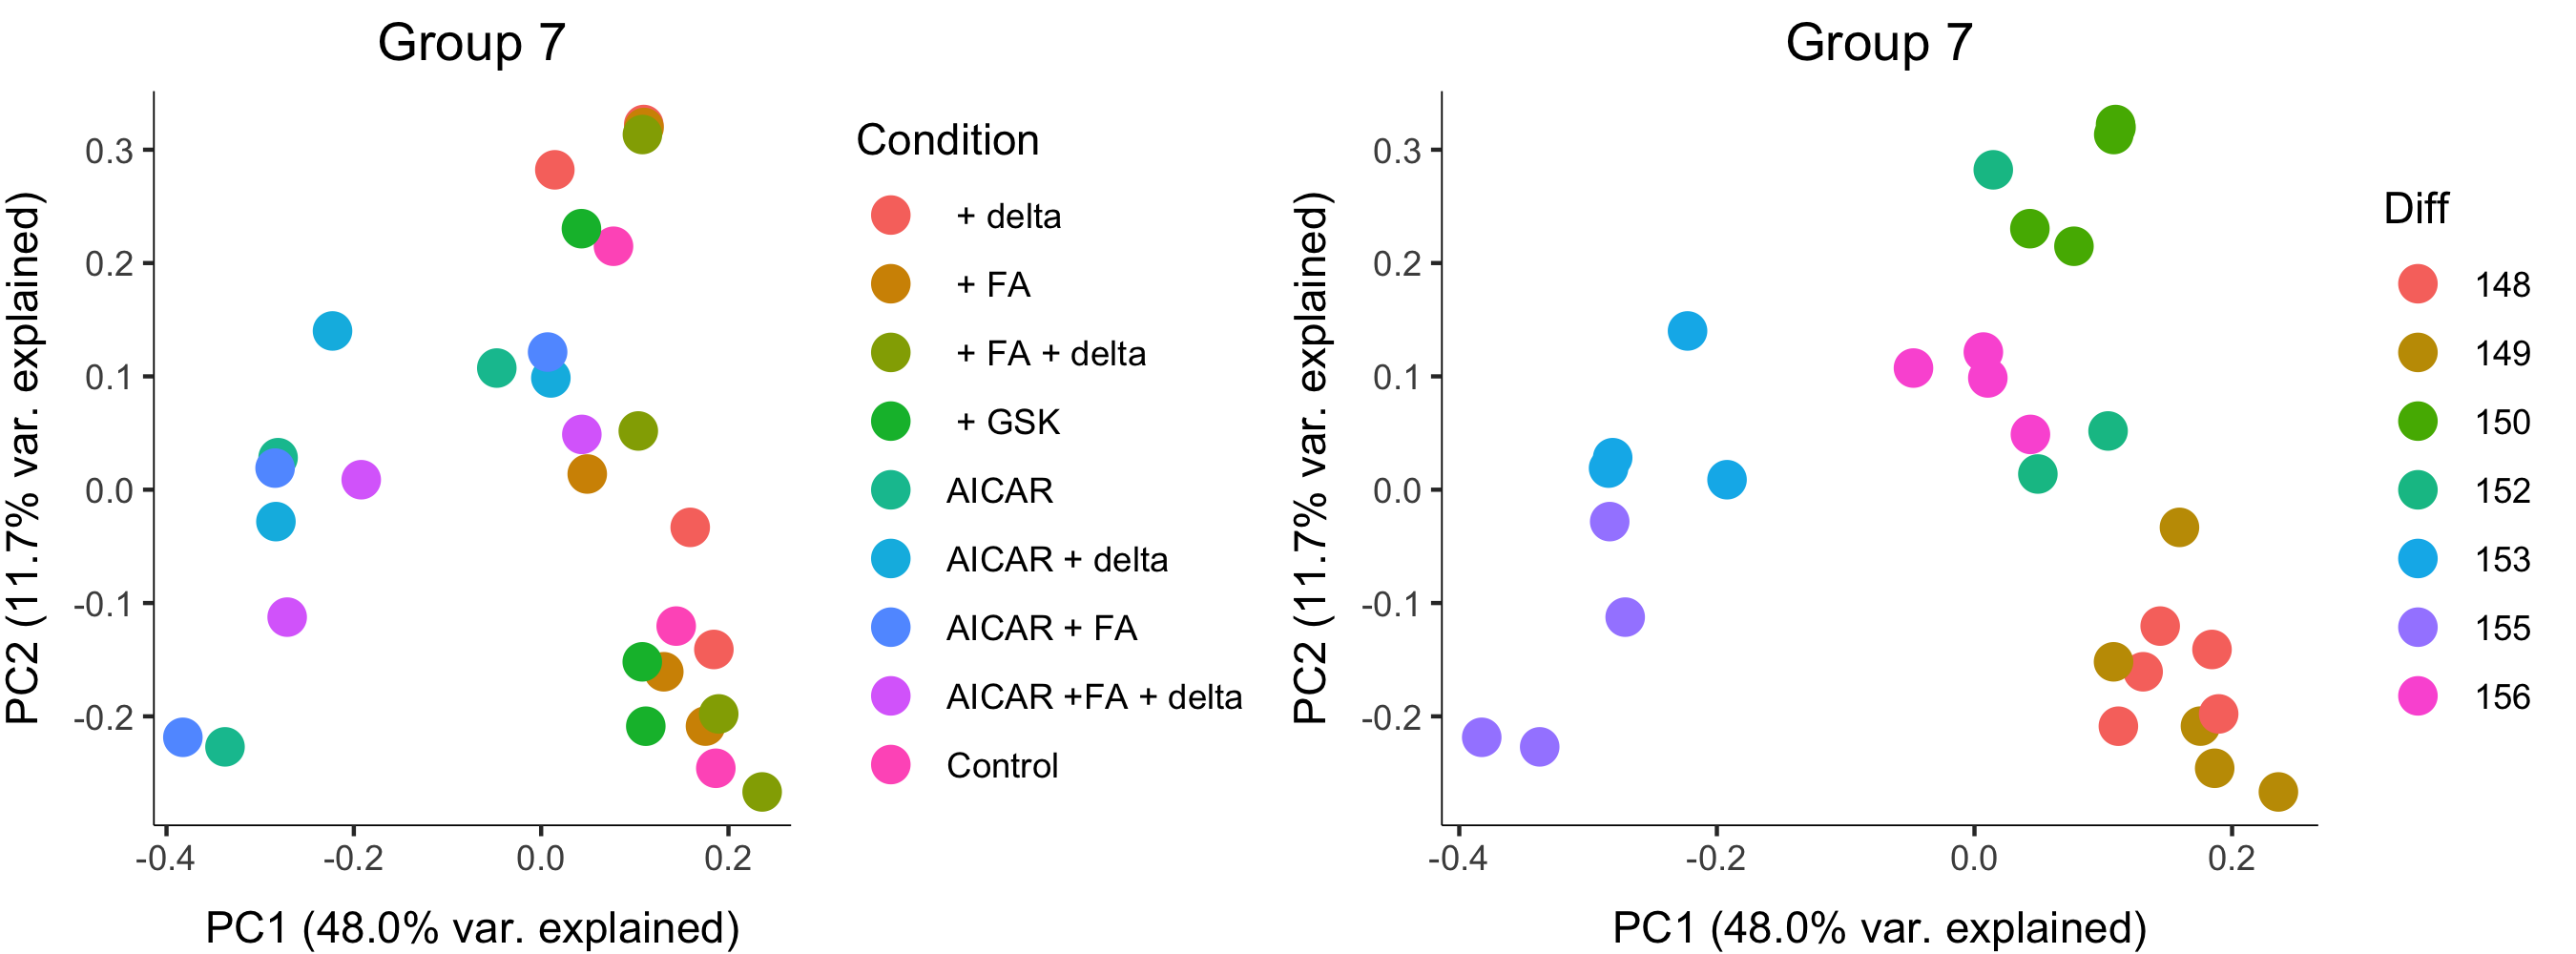

In [157]:
# Read
with open('pipeline/notebooks/dubois_groups.json', 'r') as openfile:
    groups = json.load(openfile)

# Loop
for group_name, conditions in groups.items():
    plot_pca(group_name, conditions)

## 2. Heatmap

In [124]:
def plot_heatmap(group_name, conditions):
    
    # Subset
    metadata_dataframe_subset = metadata_dataframe.query('Condition in {}'.format(conditions)).drop('Description', axis=1)
    count_dataframe_subset = count_dataframe[metadata_dataframe_subset.index]

    # Filter and normalize
    logcpm_dataframe_subset = np.log10((count_dataframe_subset/count_dataframe_subset.sum())*10**6+1)
    gene_subset = logcpm_dataframe_subset.var(axis=1).sort_values(ascending=False).index[:1000]
    heatmap_dataframe = logcpm_dataframe_subset.loc[gene_subset]

#     sns.clustermap(heatmap_dataframe, z_score=0, cmap='RdBu_r');
    display(Markdown('### '+group_name))
    %R -h 500 -w 800 -i heatmap_dataframe,metadata_dataframe_subset,group_name plot_pheatmap(heatmap_dataframe, metadata_dataframe_subset)

In [125]:
%%R
plot_pheatmap <- function(heatmap_dataframe, metadata_dataframe_subset) {
    require(pheatmap)
    pheatmap(heatmap_dataframe, annotation_col=metadata_dataframe_subset, fontsize_row=0.1) 
}

### Group 1

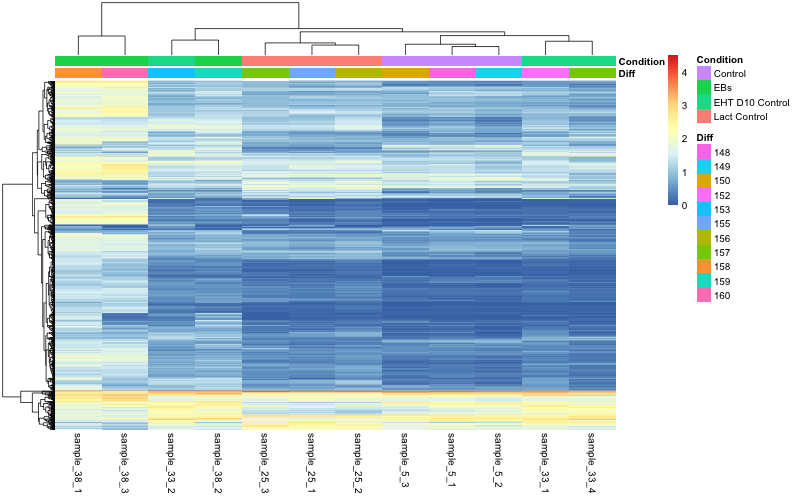

### Group 2

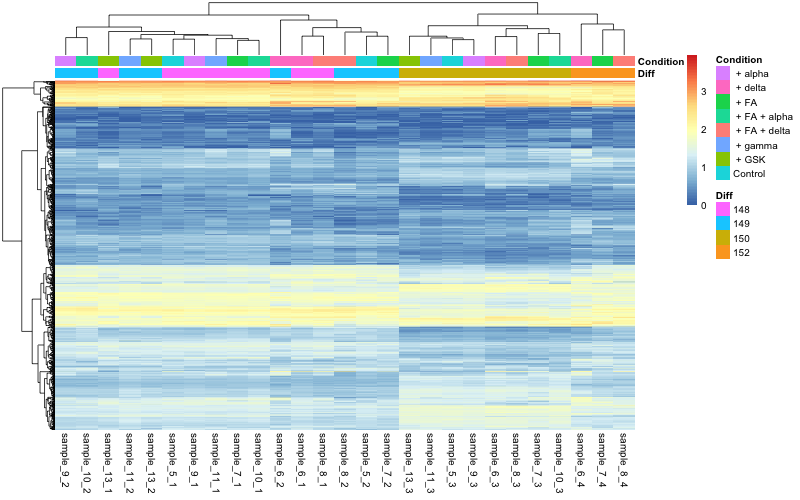

### Group 3

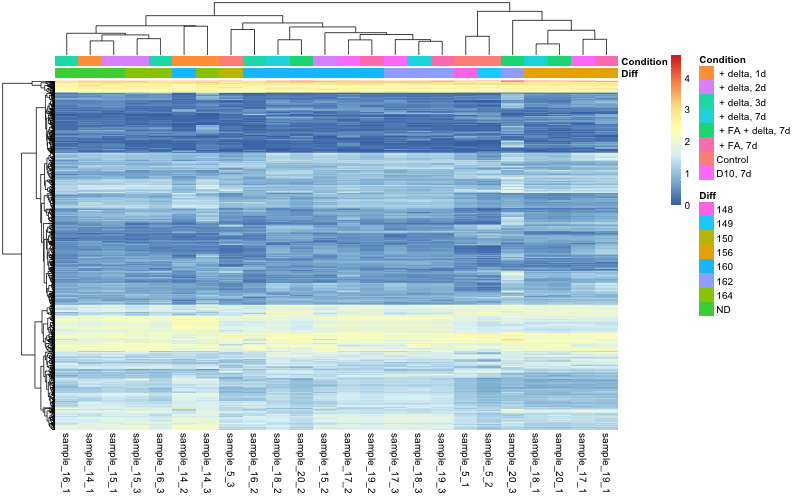

### Group 4

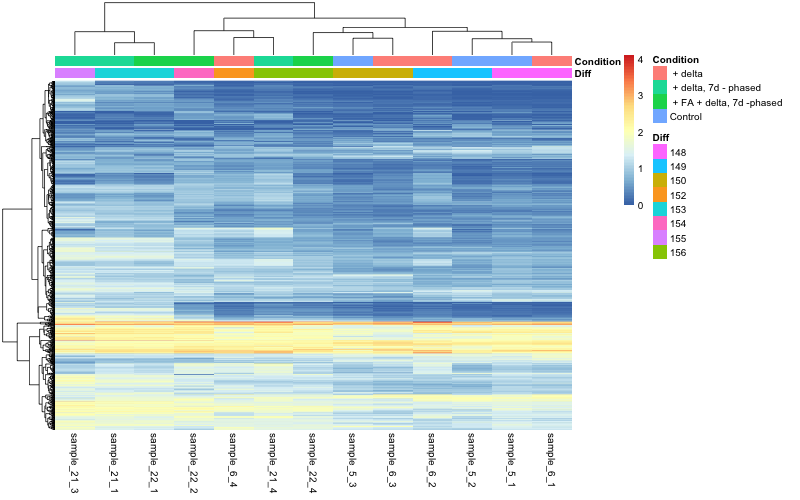

### Group 5

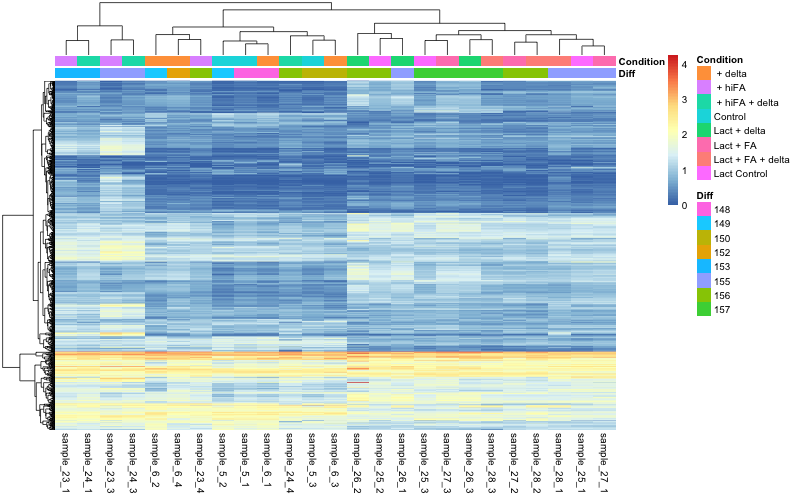

### Group 6

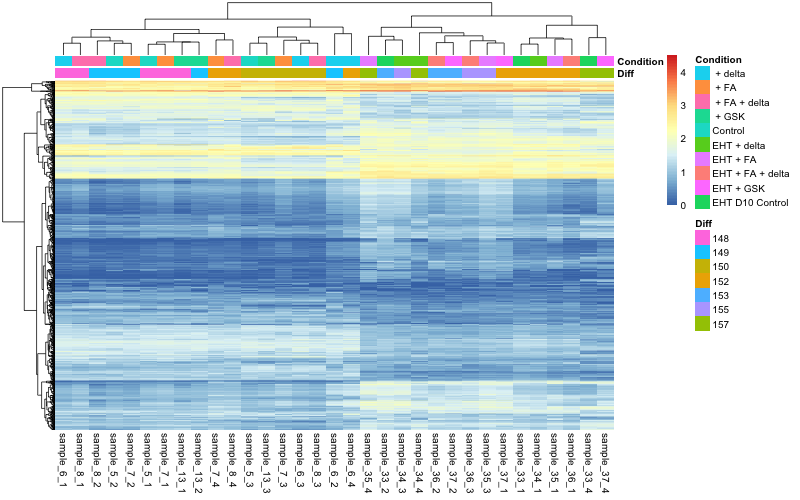

### Group 7

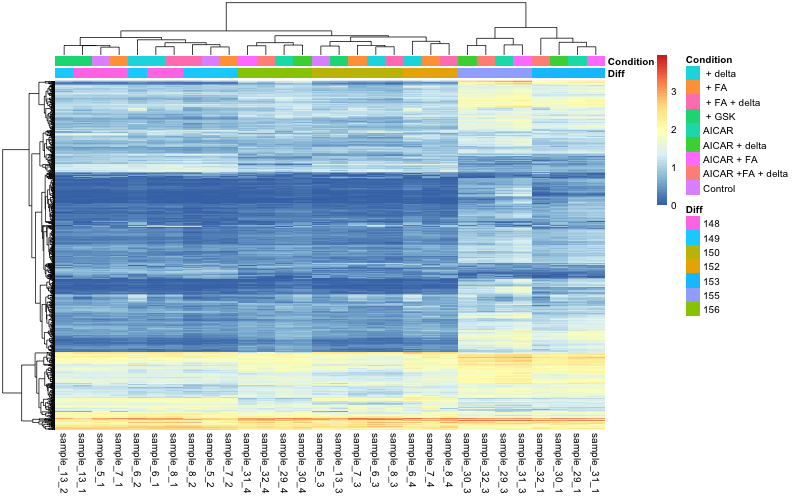

In [126]:
# Loop
for group_name, conditions in groups.items():
    plot_heatmap(group_name, conditions)